In [1]:
import geopandas as gpd
from shapely.geometry import Polygon, Point
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
# Load Data
turbines = pd.read_excel('Data/Turbines_At_Whitelee_Wind_Farm.xlsx')
lake_df = pd.read_csv('Data/Lake_Boundary.csv')

In [3]:
# Get Coordinates of Turbines and Set CRS to 4326
turbines_gdf = gpd.GeoDataFrame(
    turbines, 
    geometry=gpd.points_from_xy(turbines['Longitude'], turbines['Latitude']),
    crs="EPSG:4326"
)

In [4]:
# Constructing Polygons for Unavailable Areas
lake1 = Polygon(zip(lake_df['Lake1_Longitude'].dropna(), lake_df['Lake1_Latitude'].dropna()))
lake2 = Polygon(zip(lake_df['Lake2_Longitude'].dropna(), lake_df['Lake2_Latitude'].dropna()))
lake3 = Polygon(zip(lake_df['Lake3_Longitude'].dropna(), lake_df['Lake3_Latitude'].dropna()))
lakes_gdf = gpd.GeoDataFrame({'geometry': [lake1, lake2, lake3]}, crs="EPSG:4326")


In [5]:
lat_min, lat_max = turbines['Latitude'].min(), turbines['Latitude'].max()
lon_min, lon_max = turbines['Longitude'].min(), turbines['Longitude'].max()

# Griding
grid_rows = 58
grid_cols = 73
lat_step = (lat_max - lat_min) / grid_rows
lon_step = (lon_max - lon_min) / grid_cols

In [6]:
grid_polygons = []
for i in range(grid_rows):
    for j in range(grid_cols):
        lat1 = lat_min + i * lat_step
        lat2 = lat_min + (i + 1) * lat_step
        lon1 = lon_min + j * lon_step
        lon2 = lon_min + (j + 1) * lon_step
        
        grid_polygons.append(Polygon([(lon1, lat1), (lon2, lat1), (lon2, lat2), (lon1, lat2)]))

# Set CRS to 4326 for Consistency
grid_gdf = gpd.GeoDataFrame({'geometry': grid_polygons}, crs="EPSG:4326")

In [7]:
# Marking the Area of Overlapping Lakes
def classify_cell(cell):
    overlap_area = sum([cell.intersection(lake).area for lake in lakes_gdf.geometry])
    cell_area = cell.area
    if overlap_area / cell_area > 0.5: 
        # Areas with more than 50% overlap marked as 2
        return 2  
    return 0 

In [8]:
grid_gdf['category'] = grid_gdf['geometry'].apply(classify_cell)

In [9]:
# Marking the Positions of Turbines
def mark_turbines(row):
    for idx, turbine in turbines_gdf.iterrows():
        if row.geometry.contains(turbine.geometry):
            return 1 
    return row['category']

In [10]:
grid_gdf['category'] = grid_gdf.apply(mark_turbines, axis=1)

/tmp/ipykernel_14272/969733900.py:7: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend()
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


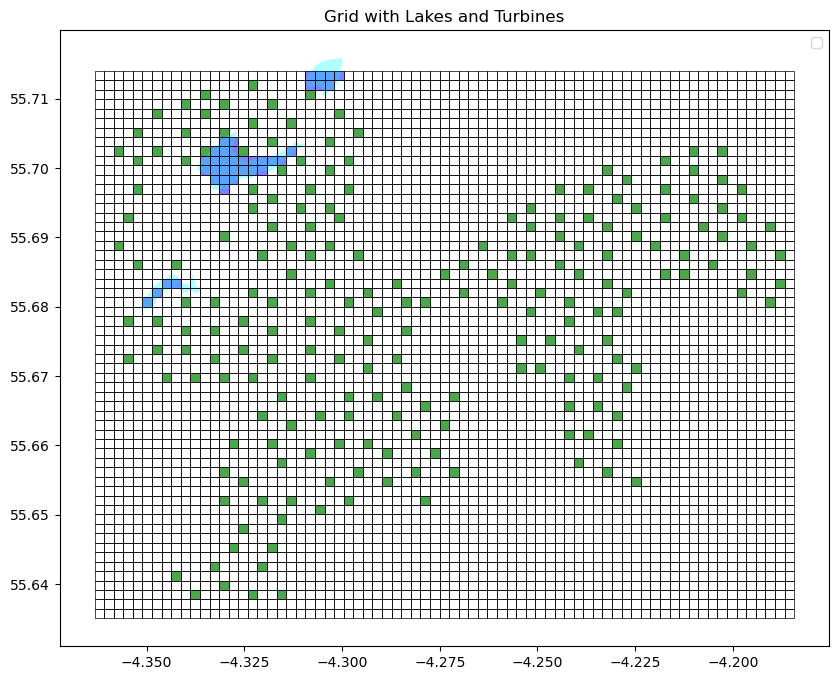

In [11]:
# Visualisation
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
grid_gdf.boundary.plot(ax=ax, color='black', linewidth=0.5)
grid_gdf[grid_gdf['category'] == 2].plot(ax=ax, color='blue', alpha=0.5, label='Lake Cells')
grid_gdf[grid_gdf['category'] == 1].plot(ax=ax, color='green', alpha=0.7, label='Turbine Cells')
lakes_gdf.plot(ax=ax, color='cyan', alpha=0.3, label='Lakes')
plt.legend()
plt.title("Grid with Lakes and Turbines")
plt.show()